<a href="https://colab.research.google.com/github/YassineSdk/Leaf_classification_transfor_learning_pytorch/blob/main/Model_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beans leaf Classification using Transform learning in Pytorch**

- in this project we are trying to classify beans leafs using a deep learning Framework Pytorch , but we won't build the model from scratch instead we we use a pretrained model that will take the knowlage from our new data this approch is called  Transfer learning , Transfer learning is a technique in machine learning where a model trained on one task (usually with a large dataset) is reused as the starting point for a model on a new, often related task (often with a smaller dataset). The key idea is that the knowledge (features, weights, etc.) learned from one problem can be applied to another problem.

- This method is particularly helpful when the dataset for the new task is small or lacks sufficient data for training a model from scratch.

### **Loading the data from kaggle using the opendatasets package**

In [74]:
! pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in "./bean-leaf-lesions-classification" (use force=True to force download)


### **Importing the packages**

In [75]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os
sns.set_theme('notebook')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device )

cuda


In [76]:
"/content/bean-leaf-lesions-classification/train/bean_rust/bean_rust_train.332.jpg"

'/content/bean-leaf-lesions-classification/train/bean_rust/bean_rust_train.332.jpg'

In [77]:
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv('/content/bean-leaf-lesions-classification/val.csv')
train_df

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0
...,...,...
1029,train/bean_rust/bean_rust_train.29.jpg,2
1030,train/bean_rust/bean_rust_train.311.jpg,2
1031,train/bean_rust/bean_rust_train.336.jpg,2
1032,train/bean_rust/bean_rust_train.329.jpg,2


In [78]:

path_start = "/content/bean-leaf-lesions-classification/"
val_df['image:FILE'] = path_start + val_df['image:FILE']
val_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/val/...,0
1,/content/bean-leaf-lesions-classification/val/...,0
2,/content/bean-leaf-lesions-classification/val/...,0
3,/content/bean-leaf-lesions-classification/val/...,0
4,/content/bean-leaf-lesions-classification/val/...,0


In [79]:
train_df['image:FILE'] = path_start + train_df['image:FILE']

In [80]:
val_df

,image:FILE,category
0,/content/bean-leaf-lesions-classification/val/...,0
1,/content/bean-leaf-lesions-classification/val/...,0
2,/content/bean-leaf-lesions-classification/val/...,0
3,/content/bean-leaf-lesions-classification/val/...,0
4,/content/bean-leaf-lesions-classification/val/...,0
...,...,...
128,/content/bean-leaf-lesions-classification/val/...,2
129,/content/bean-leaf-lesions-classification/val/...,2
130,/content/bean-leaf-lesions-classification/val/...,2
131,/content/bean-leaf-lesions-classification/val/...,2


In [81]:
print(f'training data :{train_df.shape} ')
print(f'training data :{val_df.shape} ')


training data :(1034, 2) 
training data :(133, 2) 


In [82]:
# checking the lanbels
train_df['category'].unique()

array([0, 1, 2])

Text(0.5, 1.0, 'count of Categories / valudation')

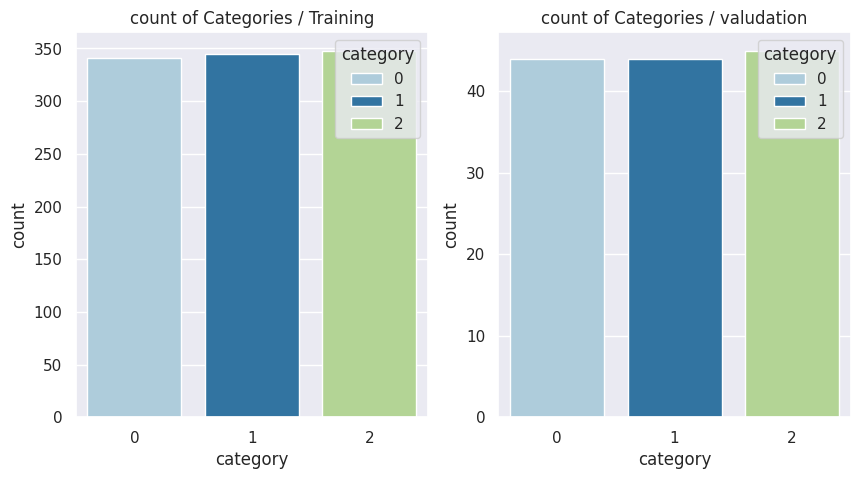

In [83]:
# checking if our data is balanced
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=train_df['category'],hue=train_df['category'],palette='Paired')
plt.title('count of Categories / Training')
plt.subplot(1,2,2)
sns.countplot(x=val_df['category'],hue=val_df['category'],palette='Paired')
plt.title('count of Categories / valudation')

# we can see that our data is balanced and the categories are distributed evenly .

### **Data preprocessing**

In [84]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [85]:

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)])

class Custom_data(Dataset):
  def __init__(self,dataframe,transform):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(self.dataframe['category']).to(device)

  def __len__(self):
      return self.dataframe.shape[0]

  def __getitem__(self,idx):
      img_path = self.dataframe.iloc[idx, 0]
      label = self.labels[idx]
      image = Image.open(img_path)
      if self.transform:
        image = self.transform(image).to(device)
        return image , label


In [86]:
train_data = Custom_data(train_df, transform)
val_data = Custom_data(val_df, transform)

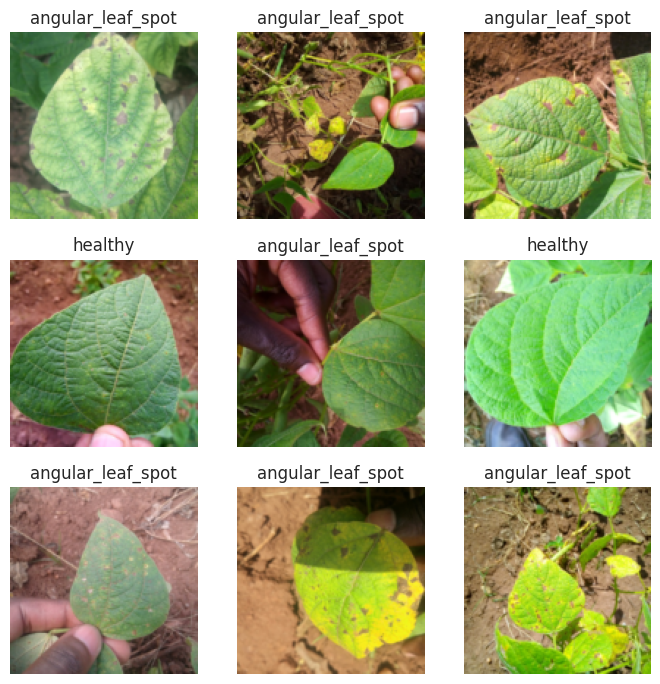

In [87]:
labels = {0:"healthy",
          1:"angular_leaf_spot",
          2:"angular_leaf_spot"}

rows = 3
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(7, 7))
ax = ax.flatten()

for i in range(rows * cols):
    idx = np.random.randint(0, len(train_data))
    image, label = train_data.__getitem__(idx)
    image = image.permute(1, 2, 0).cpu().numpy()
    ax[i].imshow(image)
    ax[i].set_title(labels[label.item()])
    ax[i].axis('off')

plt.tight_layout()
plt.show()


### **building the model**

In [88]:
lr = 1e-3
BATCH_SiZE = 4
EPOCHS = 15


In [89]:
train_loader = DataLoader(train_data,batch_size=BATCH_SiZE,shuffle=True)
val_loader = DataLoader(val_data,batch_size=val_data.__len__(),shuffle=True)

In [90]:
google_net = models.googlenet(weights="DEFAULT")

In [91]:
for param in google_net.parameters():
  # allowing the model to learn again
  param.requires_grad = True


In [92]:
# our model expect a tensor of size 1024 and it ouputs 1000 probability so we need to change that to fit our data
google_net.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [93]:
num_class = len(train_df['category'].unique())
google_net.fc = torch.nn.Linear(google_net.fc.in_features,num_class)
google_net.fc
google_net.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [94]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(google_net.parameters(),lr=lr)

t_train_loss = []
t_train_acc = []

for ep in range (EPOCHS):
  total_loss_train = 0
  total_acc_train = 0
  for input , label in train_loader :
    optimizer.zero_grad()
    preds = google_net(input)

    loss = loss_fun(preds,label)
    total_loss_train += loss.item()

    loss.backward()

    acc = (torch.argmax(preds,axis=1) == label).sum().item()
    total_acc_train += acc

    optimizer.step()
  t_train_loss.append(round(total_loss_train/1000,4))
  t_train_acc.append(round(total_acc_train/train_data.__len__()*100,4))

  print(f"epoch : {ep} | training loss : {round(total_loss_train/1000,4)} | training accuracy : {round(total_acc_train/train_data.__len__()*100,4)} %")



epoch : 0 | training loss : 0.2157 | training accuracy : 64.8936 %
epoch : 1 | training loss : 0.161 | training accuracy : 76.499 %
epoch : 2 | training loss : 0.1315 | training accuracy : 81.0445 %
epoch : 3 | training loss : 0.1175 | training accuracy : 84.8162 %
epoch : 4 | training loss : 0.0824 | training accuracy : 88.7814 %
epoch : 5 | training loss : 0.0862 | training accuracy : 88.6847 %
epoch : 6 | training loss : 0.0778 | training accuracy : 89.4584 %
epoch : 7 | training loss : 0.0655 | training accuracy : 91.4894 %
epoch : 8 | training loss : 0.0649 | training accuracy : 91.4894 %
epoch : 9 | training loss : 0.0663 | training accuracy : 91.0058 %
epoch : 10 | training loss : 0.0329 | training accuracy : 96.4217 %
epoch : 11 | training loss : 0.0501 | training accuracy : 93.2302 %
epoch : 12 | training loss : 0.043 | training accuracy : 94.8743 %
epoch : 13 | training loss : 0.0477 | training accuracy : 93.7137 %
epoch : 14 | training loss : 0.0435 | training accuracy : 94.

### **training and loss  evolution of our model**

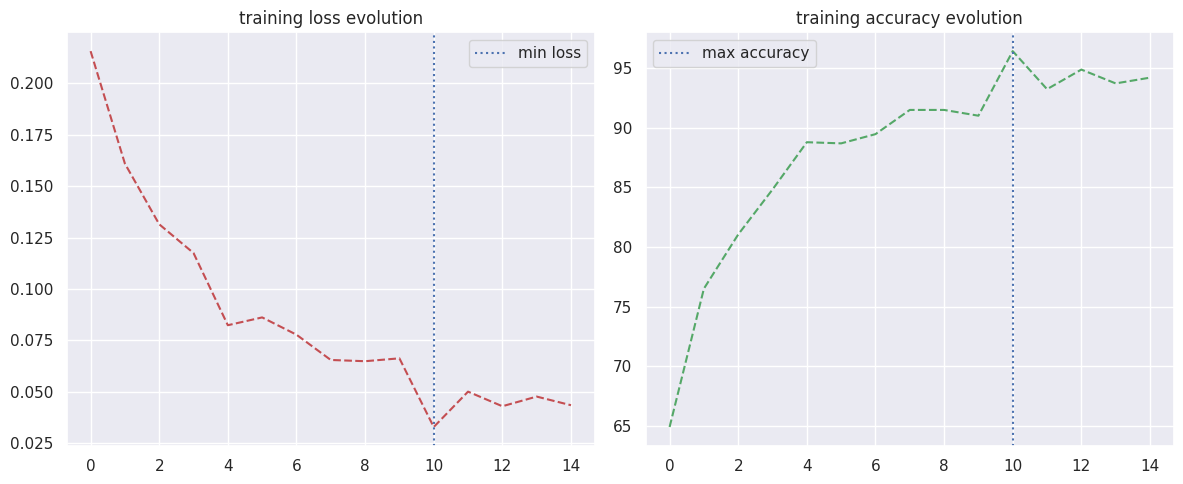

In [95]:
sns.set_theme('notebook')
plt.figure(figsize=(12,5),layout='tight')
plt.subplot(1,2,1)
plt.plot(np.arange(0,15,1),t_train_loss,c='r',linestyle='--')
plt.axvline(np.argmin(t_train_loss),linestyle=':',c='b',label='min loss')
plt.title('training loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0,15,1),t_train_acc,c='g',linestyle='--')
plt.axvline(np.argmax(t_train_acc),linestyle=':',c='b',label='max accuracy')
plt.title('training accuracy evolution')
plt.legend()
plt.tight_layout()

In [98]:
from sklearn.metrics import classification_report , confusion_matrix

google_net.eval()
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():  # Disables gradient computation for efficiency
    for inputs, labels in val_loader :

        # Get model predictions
        outputs = google_net(inputs)
        preds = torch.argmax(outputs, dim=1)

        # Append predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
repport = classification_report(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
print(repport)
sns.heatmap(conf_matrix,cmap='Blues',annot=True)
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.98      0.89        44
           1       0.86      0.98      0.91        44
           2       0.97      0.64      0.77        45

    accuracy                           0.86       133
   macro avg       0.88      0.87      0.86       133
weighted avg       0.88      0.86      0.86       133



Text(0.5, 19.049999999999997, 'prediction data')

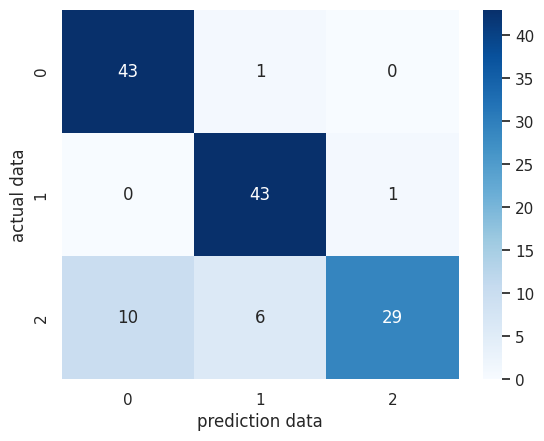

In [99]:
sns.heatmap(conf_matrix,cmap='Blues',annot=True)
plt.ylabel("actual data")
plt.xlabel("prediction data")

### **Transfor learning**

In [103]:
google_net_2 = models.googlenet(weights='DEFAULT')

for param in google_net_2.parameters():
  param.requires_grad = False
google_net_2.fc = torch.nn.Linear(google_net_2.fc.in_features,num_class)
google_net_2.fc.requires_grad = True
google_net_2.to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(google_net_2.parameters(),lr=lr)

t_train_loss = []
t_train_acc = []

for ep in range (EPOCHS):
  total_loss_train = 0
  total_acc_train = 0
  for input , label in train_loader :
    optimizer.zero_grad()
    preds = google_net_2(input)

    loss = loss_fun(preds,label)
    total_loss_train += loss.item()

    loss.backward()

    acc = (torch.argmax(preds,axis=1) == label).sum().item()
    total_acc_train += acc

    optimizer.step()
  t_train_loss.append(round(total_loss_train/1000,4))
  t_train_acc.append(round(total_acc_train/train_data.__len__()*100,4))

  print(f"epoch : {ep} | training loss : {round(total_loss_train/1000,4)} | training accuracy : {round(total_acc_train/train_data.__len__()*100,4)} %")


epoch : 0 | training loss : 0.2342 | training accuracy : 54.352 %
epoch : 1 | training loss : 0.1906 | training accuracy : 68.0851 %
epoch : 2 | training loss : 0.178 | training accuracy : 69.7292 %
epoch : 3 | training loss : 0.1796 | training accuracy : 69.2456 %
epoch : 4 | training loss : 0.1784 | training accuracy : 70.5996 %
epoch : 5 | training loss : 0.17 | training accuracy : 72.0503 %
epoch : 6 | training loss : 0.1653 | training accuracy : 71.3733 %
epoch : 7 | training loss : 0.1778 | training accuracy : 70.2128 %
epoch : 8 | training loss : 0.1813 | training accuracy : 70.8897 %
epoch : 9 | training loss : 0.1865 | training accuracy : 69.6325 %
epoch : 10 | training loss : 0.1744 | training accuracy : 73.2108 %
epoch : 11 | training loss : 0.1715 | training accuracy : 72.7273 %
epoch : 12 | training loss : 0.1621 | training accuracy : 74.5648 %
epoch : 13 | training loss : 0.1672 | training accuracy : 73.4043 %
epoch : 14 | training loss : 0.1627 | training accuracy : 73.7

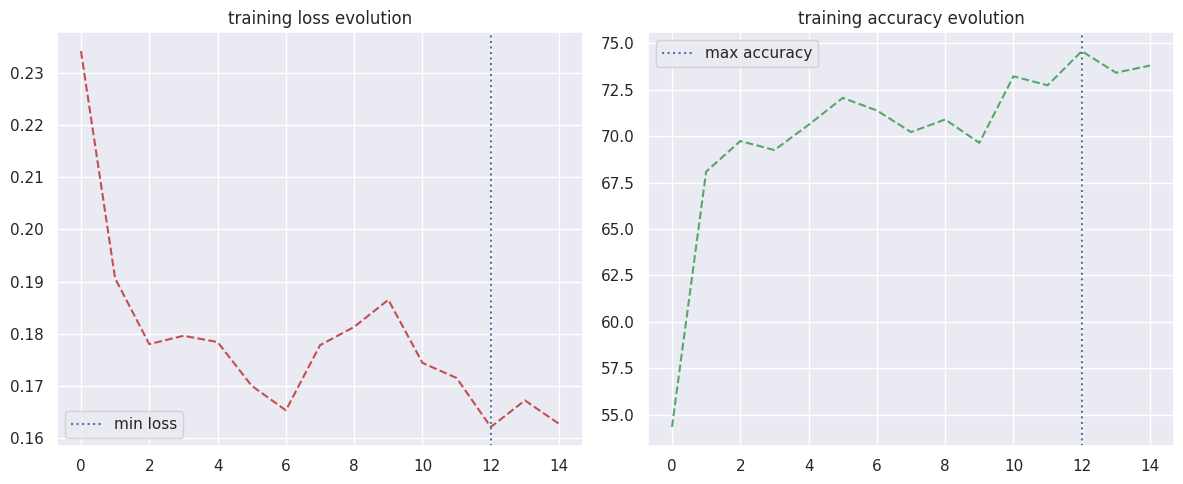

In [104]:
sns.set_theme('notebook')
plt.figure(figsize=(12,5),layout='tight')
plt.subplot(1,2,1)
plt.plot(np.arange(0,15,1),t_train_loss,c='r',linestyle='--')
plt.axvline(np.argmin(t_train_loss),linestyle=':',c='b',label='min loss')
plt.title('training loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0,15,1),t_train_acc,c='g',linestyle='--')
plt.axvline(np.argmax(t_train_acc),linestyle=':',c='b',label='max accuracy')
plt.title('training accuracy evolution')
plt.legend()
plt.tight_layout()

              precision    recall  f1-score   support

           0       0.93      0.86      0.89        44
           1       0.66      0.70      0.68        44
           2       0.69      0.69      0.69        45

    accuracy                           0.75       133
   macro avg       0.76      0.75      0.75       133
weighted avg       0.76      0.75      0.75       133



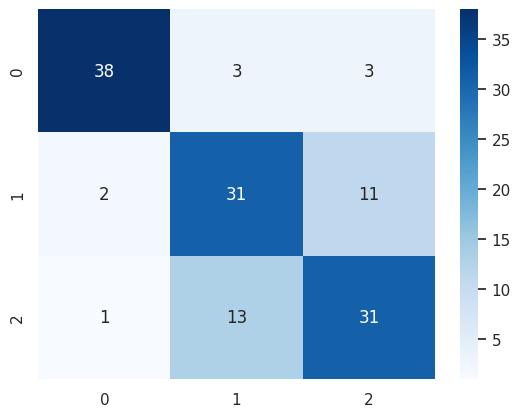

In [105]:
google_net_2.eval()
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():  # Disables gradient computation for efficiency
    for inputs, labels in val_loader :

        # Get model predictions
        outputs = google_net_2(inputs)
        preds = torch.argmax(outputs, dim=1)

        # Append predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
repport = classification_report(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
print(repport)
sns.heatmap(conf_matrix,cmap='Blues',annot=True)
plt.show()